## DERIVATIVES PRICING FUNCTIONS
* This notebook functions as a bit of an introduction to the underlying theory of options pricing, introducing some concepts like the blackscholes model, implied volatility, brownian motion, geometric brownian motion, (vanilla and exotic) options, and monte carlo techniques. 
    * Naturally, the accompanying code which implements the introduced theory follows the theoretical introduction in each section
    * Additionally, some analysis is given to the computational benefits of vectorising particular operations in options pricing depending on the underlying assumptions / option- which can yield significantly quicker results with just small changes in the underlying code

# TABLE OF CONTENTS
* [Introduction to blackscholes model & assumptions](#bs_baseline)
    * [Implied Volatility](#iv)
* [Tree pricing methods for vanilla options (American / European)](#tree_pricing)
* [Introduction to Monte Carlo & Brownian Motion](#bm)
    * [Extension to Geometric Brownian Motion](#gbm)
* [Monte Carlo supporting math and theory breakdown](#mc_theory)
* [Applications of MC pricing: Exotic Options](#exotic_options)
* [Variance Reduction techniques in MC pricing](#vr_mc)

###  Future Planned Content / Expansion
* Add 2nd variance reduction method (control variates) & compare to antithetic sampling + do a combined version
* Add a LSTM model for MC pricing American Options

* improve the robustness of the examples with a sub-sample of real options data
    * Thus, could Add GARCH models for volatility forecasts/estimates in the pricing models to better reflect real situations 

In [2]:
## import packages
from scipy.stats import norm
from scipy.optimize import brentq
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

<a id='bs_baseline'></a>


## BLACKSCHOLES MODEL 
* functions as a sort of baseline model for appraising options
* Can be "reverse engineered" to return the implied volatility (volatility implied by quoted/traded options in real life) - (next section)
* In some instances, E.G. for european options- the BSM is a closed form solution for pricing European options (but not for American options due to the possibility of early exercise)

### RESTRICTIVE ASSUMPTIONS OF BLACKSCHOLES MODEL (BSM):
* Only works for European options (exercised at expiration)
* No dividends paid out during the option's life, but an optional adjustment for averaged dividend yield is possible
    * NOTE: traditional assumption is no dividends whatsoever
* No transaction or comissions costs
* Returns are log-normally distributed
* BSM assumes that volatility is constant (like a photo taken at the time of calculation)
    * This is perhaps the most unpractical assumption of the model and explains why you cannot use the BSM for real life options trading; as the assumption that volatility is constant for the life of the option is entirely unfeasible

### Parameters:
    * S0 = stock price
    * K = Strike
    * T = time to maturity E.G. (3/12) = 3M 
    * r = risk-free rate (discount rate)
    * sigma = volatility
    * q = (default=0) dividend % yield 

In [2]:
def blackscholes(S0, K, T, r, sigma, Type='call', q=0):
    """
    Price of a European (call or put) in the Black-Scholes model with optional dividend parameter (default=0)
    
    """
    
    d1 = (np.log(S0)-np.log(K)+((r-q)+sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1-sigma*np.sqrt(T)
    
    if Type=='call':
        return S0*norm.cdf(d1)-np.exp((-r-q)*T)*K*norm.cdf(d2)

    elif Type =='put': 
        return K*np.exp((-r-q)*T)*norm.cdf(-d2) - S0*np.exp((-r-q)*T)*norm.cdf(-d1)

    # intentionally catch potential mistypes instead of just an else=put set-up
    else:
        raise TypeError("Option type is not valid, choose from: ['call','put']")

In [3]:
# hypothetical parameters:
S0=11.; K=10.; T=3/12.; r=.02; sigma=.3

In [4]:
blackscholes(S0, K, T, r, sigma, Type='call')

1.2858368491569285

In [5]:
blackscholes(S0, K, T, r, sigma, Type='put')

0.24849879216819515

### PASSING IN AN ARRAY OF STRIKES
* instead of a singular value for strike (K) - can visualise the price of the option across an array of different strike values

In [22]:
#e.g. of range of strikes
np.linspace(8, 17, 10)

array([ 8.,  9., 10., 11., 12., 13., 14., 15., 16., 17.])

In [23]:
# pass in this array of strike values into the black scholes function to see prices
Ks = np.linspace(8, 17, 10)
blackscholes(S0, Ks, T, r, sigma, Type='call', q=0)

array([3.04764278e+00, 2.10292676e+00, 1.28583685e+00, 6.83793268e-01,
       3.15424426e-01, 1.27387743e-01, 4.57330579e-02, 1.48431228e-02,
       4.42638119e-03, 1.23061993e-03])

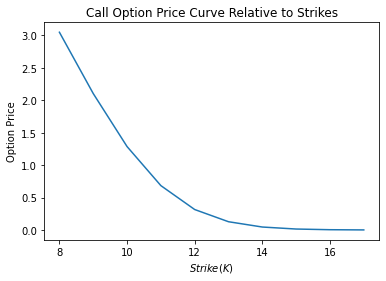

In [26]:
# plot the impact of strike (K) on prices (call)
plt.plot(Ks, blackscholes(S0, Ks, T, r, sigma, Type='call', q=0))
plt.xlabel("$Strike (K)$")
plt.ylabel("Option Price")
plt.title("Call Option Price Curve Relative to Strikes");

<a id='iv'></a>


## IMPLIED VOLATILITY

* The *implied volatility* (IV, $\sigma _{I}$) of an option is that value of $\sigma $ which equates the BS model price to the observed market price $C_{0}^{obs}$, i.e., it solves
<br><br>
$$
C_{0}^{obs}=BS(S_{0},K,T,r,\sigma_I).
$$
<br>
* If the BS assumptions were correct, then any option traded on the asset should have the same IV, which should in turn equal historical volatility.

* In practice, options with different strikes $K$ and hence *moneyness* $K/S_{0}$ have different IVs: this gives rise to the famous: *volatility smile* or *smirk/skew*.

    * Also, options with different times to maturity have different IVs: this yields what is known as the *volatility term structure*.

* These phenomena (different moneyness = different IV) and (different times to maturity = different IV) are evidence of a failure of the assumptions of the Black-Scholes model
    * As mentioned above, the most important failure of the BSM (and why you cannot use it to trade in practice) that of a constant volatility $\sigma$.

In [31]:
def impvol(S0, K, T, r, C_obs, Type='call'): 
    """
    Implied Black-Scholes volatility- With Root Finding Function: Scipy Brentq
    
    """
    
    ## if != call; can convert to call price via parity
    if Type == 'put':  
        C_obs = C_obs+S0-np.exp(-r*T)*K
        
    ## else if type = call (function default behaviour)   
    
    # theranchi bounds (lower and upper)
    # represent upper and lower bounds which hold uniformly across moneyness and call price
    # these bounds are used to reprove uniform bounds on IV at extreme strikes and/or maturities
    L = -2*norm.ppf((S0-C_obs)/(2.0*min(S0, np.exp(-r*T)*K)))/np.sqrt(T)
    U = -2*norm.ppf((S0-C_obs)/(S0+np.exp(-r*T)*K))/np.sqrt(T)
    
    #Partial application would be:  f(s)=BS(S0, K, T, r, s)-C_obs.
    return brentq(lambda s: blackscholes(S0, K, T, r, s)-C_obs, L, U)  

In [32]:
## dummy data for now (C_obs = call price observed in the market)
C_obs=3 

# hypothetical parameters:
S0=11.; K=10.; T=3/12.; r=.02; sigma=.3; N=500;

In [33]:
IV = impvol(S0, K, T, r, C_obs)
print("Implied Volatility: {}".format(IV))

Implied Volatility: 1.1854766702441244


In [49]:
# equivalent to re-running the blackscholes from above with the implied volatility (IV) in place of sigma
blackscholes(S0, K, T, r, IV) # IV replaces sigma

# returns the original passed value for C_obs of ~ 3.0

3.0000000000000178

* This data is for illustrative purposes, the level of implied volatility is very high as the call option price is very high relative to the "moneyness" of the option (K/S); additionally, a high IV pushes up the value of both call and put options

<a id='tree_pricing'></a>


## TREE OPTION PRICING 
* Specifications: 
    * Call / Put
    * American / European

In [15]:
def optiontree_flexible(S0, K, T, r, sigma, N, Type='call', option_spec='american'):
    """
    Calculate (American or European) (call & put) prices based on a N-step binomial tree: 
    """
    
    # define delta_t (Time to maturity / number of steps)
    deltaT = T / float(N)
    
    # define the factor by which the (up) movement rises
    u = np.exp(sigma*np.sqrt(deltaT))
    
    # define d in such a way the tree is recombinant 
    d = 1.0 / u
    
    # define probabilities according to the theory of risk neutral valuation
    p = (np.exp(r*deltaT)-d) / (u-d)
    
    # probabilities (up) and (down) = piu and pid respectively
    piu = np.exp(-r*deltaT) * p
    pid = np.exp(-r*deltaT) * (1-p)
    
    # calculate the stock price tree (stock price at origination * up(down) movement factors relative to position in tree
    S = S0 * u**np.arange(N+1) * d**(2*np.arange(N+1)[:, np.newaxis])
    
    #keep only the upper triangular part (as only non-negative payoffs contribute to price) 
    S = np.triu(S)  
    
    if Type =='call':
        
        # initialise the matrix of zeros to be written over for (when payoff > 0) for the payoff structure 
        C = np.zeros((N+1, N+1))
        
        # calculate the payoff for each node in the tree through to (N) steps: larger of (0, or stock - strike price) for call
        C[:, N] = np.maximum(0, S[:, N]-K) 

        # iterate backwards through tree to multiply payoffs by probability of being in that node
        for j in range(N-1, -1, -1):
            C[:j+1, j] = piu * C[:j+1, j+1] + pid * C[1:j+2, j+1]
            
            # if option = American; calculate the value of early exercise
            if option_spec == 'american':
                C[:j+1, j] = np.maximum(K-S[:j+1, j], C[:j+1, j] )

        # return the price of the option at origination (which is the weighted sum of payoffs * probabilities) in the tree    
        return  np.round(C[0, 0],6)
    
    elif Type =='put':
        # initialise matrix of zeros (could use C again but for clarity, rename it to P)
        P = np.zeros((N+1,N+1))
        
        # calculate payoff- for put is: maximum of (0, strike-stock)
        P[:, N]=np.maximum(0, K-S[:, N])
        
        # iterate through tree of payoffs and probabilities
        for j in range(N-1, -1, -1):
            P[:j+1, j] = piu * P[:j+1, j+1] + pid * P[1:j+2, j+1]
            
            # if option = American; calculate the value of early exercise
            if option_spec =='american':
                P[:j+1, j] = np.maximum(P[:j+1, j], K-S[:j+1, j] )
    
        # return price at origination
        return  np.round(P[0, 0],6)    
    
    

In [4]:
# hypothetical parameters:
S0=11.; K=10.; T=3/12.; r=.02; sigma=.3; N=500;

In [11]:
optiontree_flexible(S0, K, T, r, sigma, N, Type='call', option_spec='european')

1.28574

In [12]:
optiontree_flexible(S0, K, T, r, sigma, N, Type='put', option_spec='european')

0.235864

In [13]:
optiontree_flexible(S0, K, T, r, sigma, N, Type='call', option_spec='american')

1.522124

In [34]:
optiontree_flexible(S0, K, T, r, sigma, N, Type='put', option_spec='american')

0.236918

<a id='bm'></a>

# MONTE CARLO PRICING SECTION OUTLINE
* Introduce Brownian Motion / Geometric Brownian Motion
* Introduce Exotic Options & MC pricing 
* Introduce Sampling Variance Reduction Techniques
* Apply Methodology to Vanilla Options


## BRIEF INTRODUCTION TO BROWNIAN MOTION / GEOMETRIC BROWNIAN MOTION
* In the Monte Carlo (MC) simulations, we need a way to simulate the underlying asset price path. The payoffs are path dependent, and the payoff function does not change over time, simply the value of the underlying asset price which affects the (expected) payoff, and hence the price of the option


### SIMULATING BM OUTLINE
* We need to discretize it, spliting the time interval $[0,T]$ into $N$ parts of length $\delta t=T/N$ 
* Now we model the asset's return (price path) $R_{i}$ as normal (rather than binomial in a tree pricer)
    * thus: $$
R_{i}=\sqrt{\delta t}\cdot Z_i,\quad Z_i\sim\mathrm{N}(0, 1).
$$
    * Where Z is a random sample from the normal distribution (or pseudo random from numpy's (np.random.randn)) 
    
    
#### BM with drift: 
* As a slight generalization, a *Brownian motion with drift* is obtained from
$$
\delta X_t \equiv  X_{i\delta t}-X_{(i-1)\delta t} =\mu\delta t+\sigma\delta W_{t}=\mu\delta t+\sigma\sqrt{\delta t} Z_i,
$$
* where we let the change in one time interval essentialy be equal to a drift term + the volatility term
    * Also, where we allow $X_0$ to be an arbitrary value. (that is, the starting value is not important)


* This implies
$$
X_t\equiv X_0+\mu t +\sigma W_t,
$$
so that $\mathbb{E}[X_t]=X_{0}+\mu t$, $\mathrm{Var}[X_t]=\sigma^{2}t$. 
    * Hence the average upwards (or downwards if $\mu<0$) tendency over a time interval $\delta t$ is $\mu \delta t$.

In [11]:
def bmsim(T, N, X0=0, mu=0, sigma=1):
    """Simulate a Brownian motion path with X0/mu = 0 drift terms"""
    
    # define our time interval 
    deltaT = float(T)/N
    
    # create the linearly spaced vector of 0 through T, in increments of N + 1
    tvec = np.linspace(0, T, N+1)
    
    # generate random variable from normal distribution to simulate the "randomness" of the process
    z = np.random.randn(N+1)   
    
    # define the change in process (X) as the formula written above for BM 
    dX = mu*deltaT + sigma*np.sqrt(deltaT)*z  
    
    # define starting point for the process
    dX[0] = 0.
    
    # sum the total changes made to the process (X) with (drift if != 0 and volatility)
    # we can vectorise this because the elements are not time varying and don't require the previous period's values
    X = np.cumsum(dX)
    
    # return origination value to apply the cumsum of changes to the starting price/level of the process
    X += X0    
    return tvec, X

[ 0.          0.01265408  0.04360449 ... -1.47560242 -1.48692698
 -1.4693459 ]


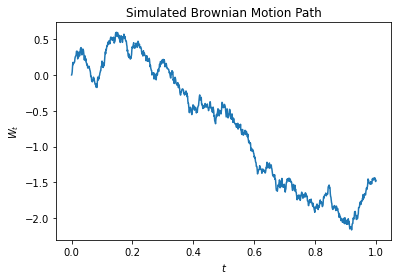

In [6]:
#E.G. of brownian motion path (with a set random seed)
np.random.seed(0)
tvec, W = bmsim(1, 1000)
W = pd.Series(W, index=tvec)
W.plot()
plt.title('Simulated Brownian Motion Path')
plt.xlabel("$t$"); plt.ylabel("$W_t$");

<a id='gbm'></a>

### GEOMETRIC BROWNIAN MOTION (GBM)
* Ito processes generalise BM with drift by allowing both the drift and volatility to be time-varying.

* We can now re-write the above BM expression as: 
$$
\delta X_t\equiv X_{i\delta t}-X_{(i-1)\delta t}=\mu_{t_{i-1}} \delta t + \sigma_{t_{i-1}} \delta W_t.
$$


* We allow $\mu_{t_i}$ and $\sigma_{t_i}$ to be stochastic; e.g., they may depend on $X_{i-1}$, as in 
$$
\delta X_t=\mu(t_{i-1},X_{i-1}) \delta t + \sigma(t_{i-1}, X_{i-1}) \delta W_t.
$$




####  **An example of an Ito process**: 
* Take $\mu(t, S_t)\equiv \mu S_t$ and $\sigma(t, S_t)\equiv \sigma S_t$. The resulting process
$$
dS_t=\mu S_t dt +\sigma S_t dW_t
$$
is known as Geometric Brownian Motion (*GBM*). 
    * Its Euler approximation is
$$
\delta S_t \equiv S_{i}-S_{i-1}=\mu S_{i-1} \delta t + \sigma S_{i-1}  \sqrt{\delta t} Z_i.
$$

* In this approximation the distribution of $\delta S_t$ (the stock price) is normal (not log-normal as it should be)
* Under mild conditions, the error introduced by discretization will disappear as $\delta t\rightarrow 0$. (as the time interval width approaches being continuous)

In [1]:
def gbmsim(T, N, S0=1, mu=0, sigma=1):
    """
    Simulate a Geometric Brownian motion path with Mu (drift) = 0 and sigma = 1 by means of Euler Approximation
    """
    
    deltaT = float(T)/N
    
    # create the linearly spaced vector of 0 through T, in increments of N + 1
    tvec = np.linspace(0, T, N+1)
    
    # initialse random numbers through N + 1 for the shape from the normal distribution
    z = np.random.randn(N+1)  
    
    # initialise an array of zeros of the same shape (to be iterated over)
    S = np.zeros_like(z)
    
    # define the starting point for the iteration to be (1)
    S[0] = S0
    
    #Note: we can no longer vectorize this, because S[:, j] is needed for S[:, j+1]. (time varying element)
    for i in range(0, N): 
        S[i+1] = S[i] + mu*S[i]*deltaT + sigma*S[i]*np.sqrt(deltaT)*z[i+1]
        
    return tvec, S

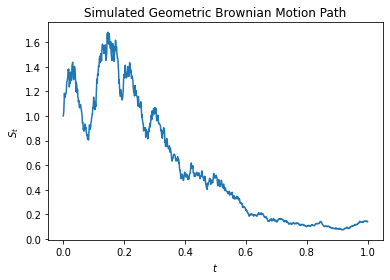

In [24]:
np.random.seed(0)
tvec, S = gbmsim(1, 1000)
S = pd.Series(S, index=tvec)
S.plot()
plt.title('Simulated Geometric Brownian Motion Path')
# x label is time; y label is stock 
plt.xlabel("$t$"); plt.ylabel("$S_t$"); 

<a id='mc_theory'></a>

# MONTE CARLO PRICING - THEORY INTRODUCTION

* The goal in Monte Carlo simulations is to obtain an estimate of (theta) denoted:

$$
\theta\equiv \mathbb{E}[X],
$$


for some random variable $X$ with finite expectation. The assumption is that we have a means of sampling from the distribution of $X$, but no closed-form expression for $\theta$. (As is the case for American options, for instance)
* Suppose we have a sample $\{X_i\}_{i\in\{1,\ldots,n\}}$ of *independent* draws for $X$, and let
$$
\bar{X}_n=\frac{1}{n}\sum_{i=1}^n X_i.
$$
* The sample average $\bar{X}_n$ is an *unbiased estimator* of $\theta$ : $\mathbb{E}[\bar{X}_n]=\theta$.
* The *weak law of large numbers* states that
$$
\bar{X}_n\stackrel p \rightarrow \theta,
$$
where the arrow denotes *convergence in probability*; i.e., as the sample size grows, $\bar X_n$ becomes a better and better estimate of $\theta$. 
    * Although, techniques exist to improve the estimate of $\theta$ (that is, reduce the sampling variance) without having to infinitely grow the sample size. This project will include two such techniques: 
        * Antithetic sampling 
        * Control variates 
        
        
## MC PROCESS OUTLINE:
* Thus, our strategy is to use a computer to draw $n$ (pseudo) random numbers $X_i$ from the distribution of $X$, and then estimate $\theta$ as the sample mean of the $X_i$.
* $n$ is called the number of *replications*.
* For finite $n$, the sample average will be an approximation to $\theta$. 
* It is usually desirable to have an estimate of the accuracy of this approximation. Such an estimate can be obtained from the *central limit theorem* (CLT), which states that
$$
\sqrt{n}(\bar{X}_n-\theta)\stackrel d\rightarrow N\left(0,\sigma^2\right),
$$
provided that $\sigma^2$, the variance of $X$, is finite. The arrow denotes convergence in distribution
    * this implies that for large $n$, $\bar{X}_n$ has approximately a normal distribution.
    
    
    
* Of course $\sigma^2$ is unknown, but we can estimate it in the traditional sense as
$$
\hat{\sigma}^2=\frac{1}{n}\sum_{i=1}^n \left(\bar{X}_n-X_i\right)^2.
$$

### CONFIDENCE INTERVALS IN MC SIMULATIONS: 
* A 95% *confidence interval* (CI) is an interval $[c_l,c_u]$ with
$
\mathbb{P}[c_l\leq \theta \leq c_u]=0.95.
$
* The CLT implies that, in the limit as $n\rightarrow\infty$,

\begin{align*}
\mathbb{P}[-1.96 \sigma\leq \sqrt{n}(\bar{X}_n-\theta)\leq 1.96 \sigma ]&=0.95\Leftrightarrow\\
\mathbb{P}[\bar{X}_n-1.96 \frac{\sigma}{\sqrt{n}}\leq \theta\leq \bar{X}_n+1.96 \frac{\sigma}{\sqrt{n}} ]&=0.95.
\end{align*}
* Hence $c_l=\bar{X}_n-1.96 \frac{\sigma}{\sqrt{n}}$ and $c_u=\bar{X}_n+1.96 \frac{\sigma}{\sqrt{n}}$ is an asymptotically valid CI.
* Note that $c_l$ and $c_u$ are random variables; we should interpret this as "before the experiment is performed, there is a 95% chance that a CI computed according to this formula will contain $\theta$". 
    * The intuition behind confidence levels in MC work slightly differently; hence, after performing the experiment, this statement is not valid anymore. The interval is now fixed, and contains $\theta$ with probability either 0 or 1.
* The unknown parameter $\sigma$ can be consistently estimated by $\sqrt{\hat{\sigma}^2}$.

<a id='exotic_options'></a>

# APPLICATIONS OF MC PRICING - EXOTIC OPTIONS: 
## (1): ASIAN OPTIONS 

* The payoff of Asian options depends on the *average* price of the underlying, $\bar{S}_T$. Types:
  * Average price Asian call with payoff $(\bar{S}_T-K)^+$;
  * Average price Asian put with payoff $(K-\bar{S}_T)^+$;
  * Average strike Asian call with payoff $(S_T-\bar{S}_T)^+$;
  * Average strike Asian put with payoff $(\bar{S}_T-S_T)^+$.


* The type of average is important in the calculation - here we consider the arithmetic average: 
$$
\qquad
\frac{1}{N}\sum_{i=1}^N S_{t_i}
$$
where the $t_i$ are a set of $N$ specified dates.

## NOTE: An exact pricing formula exists only for a geometric average asian call, hence we rely upon a MC simulation
* With the pricing formula
$$
C_{t}=e^{-r(T-t)}\mathbb{E}^{\mathbb{Q}}\left[ \left.
C_{T}\right\vert \mathcal{F}_{t}\right] 
$$


* The arithmetic average price call cannot be priced analytically, hence rely upon the MC simulation
* The asian call's payoff is: 
$$
C_T=(\bar{S}_T-K)^+,\quad\mbox{where}\quad \bar{S}_T=\frac{1}{N}\sum_{i=1}^N S_{t_i},
$$
* The payoff is *path-dependent*, so we need to simulate the entire asset price path, not just $S_T$. (the final price at maturity)


In [19]:
def asian_mc(S0, K, T, r, sigma, q, N, numsim=10000):
    """
    Monte Carlo price of an arithmetic average Asian call.
    S0 = initial stock price
    K = strike price
    T = time to maturity
    r = risk-free rate (discount rate)
    sigma = volatility
    q = dividend rate 
    N = number of steps
    ## NOTE: (r-q) is the appropriate adjustment to the discount rate (r) by dividend rate (q)
    
    """
    
    # simulate the log of the stock price 
    X0 = np.log(S0)
    
    # define our drift term for brownian motion 
    nu = r-q-.5*sigma**2
    
    # simulate the shape of zeros in the form of numsim
    payoffs = np.zeros(numsim)
    
    # iterate through the number of simulations
    for i in range(numsim):
        _, X = bmsim(T, N, X0, nu, sigma) # just need (X), hence the underscore can be discarded
        
        # simulate the exponential of (X) the stock price path in the brownian motion simulation
        S = np.exp(X)
        
        # apply our payoff function: note ignore S0 (originaiton price) in the mean
        payoffs[i] = max(S[1:].mean()-K, 0.)  #We ignore S0 in the mean.
    
    # discount the payoffs 
    g = np.exp(-r*T)*payoffs
    
    # define the discounted payoffs mean and standard deviation
    C = g.mean()
    s = g.std()
    
    # define the normal distribution 97.5% percentage point function 
    zq = norm.ppf(0.975)
    
    # define our confidence interval for lower (cl) and upper(cu) (formula in markdown above)
    Cl = C-(zq*s)/np.sqrt(numsim)
    Cu = C+(zq*s)/np.sqrt(numsim)
    
    # return C (price of option) + confidence intervals 
    return C, Cl, Cu

In [20]:
%%time

# define dummy data for testing purposes:
S0 = 11; K = 10; T = 3/12.; r = 0.02; sigma = .3; q = 0.01; N = 10

# ensure random seed for comparability
np.random.seed(0)

C0, Cl, Cu = asian_mc(S0, K, T, r, sigma, q, N); C0, Cl, Cu

Wall time: 558 ms


(1.0927262054551385, 1.0747653929130998, 1.1106870179971773)

In [14]:
%timeit asian_mc(S0, K, T, r, sigma, q, N)

462 ms ± 1.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## VECTORISE THE ASIAN MC PRICER 
* compare the outputs and time to completion 

* Will also need to alter the original BM simulation code slightly

In [35]:
## slightly alter the BM simulation to simultaneously simulate all the changes at once, to plug into the vectorised MC
#Note new input: numsim, the number of paths.

def bmsim_vec(T, N, X0=0, mu=0, sigma=1, numsim=1):  
    """Simulate a vectorised "numsim" amount of Brownian motion paths."""
    deltaT = float(T)/N
    tvec = np.linspace(0, T, N+1)
    z = np.random.randn(numsim, N+1)  
    dX = mu*deltaT + sigma*np.sqrt(deltaT)*z
    
    dX[:, 0] = 0.  
    X = np.cumsum(dX, axis=1)  
    
    X += X0    
    return tvec, X

In [36]:
# note for an explanation on each step, see the asianmc (loop version) above
def asian_mc_vec(S0, K, T, r, sigma, q, N, numsim=10000):
    """Monte Carlo price of an arithmetic average Asian call. Vectorised Version"""
    X0 = np.log(S0)
    nu = r-q-.5*sigma**2    
    
    #simulate all paths at once with the numsim altered bmsim_vecm above:
    _, X = bmsim_vec(T, N, X0, nu, sigma, numsim)
    S = np.exp(X)
    payoffs = np.maximum(S[:, 1:].mean(axis=1)-K, 0.)  
    g = np.exp(-r*T)*payoffs
    C = g.mean(); s = g.std()
    zq = norm.ppf(0.975)
    Cl = C - zq/np.sqrt(numsim)*s
    Cu = C + zq/np.sqrt(numsim)*s
    return C, Cl, Cu

In [39]:
%%time

# define dummy data for testing purposes:
S0 = 11; K = 10; T = 3/12.; r = 0.02; sigma = .3; q = 0.01; N = 10

# ensure random seed for comparability
np.random.seed(0)

C0_v, Cl_v, Cu_v = asian_mc_vec(S0, K, T, r, sigma, q, N)
C0_v, Cl_v, Cu_v

Wall time: 6 ms


(1.0927262054551385, 1.0747653929130998, 1.1106870179971773)

In [40]:
print("confidence interval band: {}".format(Cu_v - Cl_v))

confidence interval band: 0.03592162508407748


In [18]:
%timeit asian_mc_vec(S0, K, T, r, sigma, q, N)

5.4 ms ± 181 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
# check both results are identical 
np.allclose(C0_v, C0)

True

* Notice a very significant increase in speed in the vectorised version Vs. the loop with the same result

<a id='vr_mc'></a>

# VARIANCE REDUCTION TECHNIQUES IN MC PRICING
* In standard Monte Carlo, the length of the confidence interval for $\theta\equiv\mathbb{E}[X]$ is proportional to $\hat{\sigma}/\sqrt{n}$, where $\sigma$ is the standard deviation of $X$.
* Thus to increase the accuracy by a factor of 10, we need 100 times as many samples.
* Variance reduction techniques aim to improve the accuracy of the estimate, without increasing $n$. (at scale, the computational saving become non-trivial)



## METHOD (1):  ANTITHETIC SAMPLING
#### RECALL: 
* The crude MC estimate for $\theta\equiv \mathbb{E} [X]$, based on $n$ independent draws $X_i$, is
$$
\hat{\theta}\equiv \frac{1}{n}\sum_{i=1}^n X_i.
$$



* Now suppose that we can somehow sample $n$ pairs $(X_i, \tilde X_i)$, such that
  * both $X_i$ and $\tilde X_i$ are drawn from the distribution of $X$;
  * the *pairs* $(X_i, \tilde X_i)$ are independent across $i$;
  * for each $i$, $X_i$ and $\tilde X_i$ are (negatively) correlated.
* The antithetic variable estimator is then
$$
\hat{\theta}_{AV}\equiv \frac{1}{2}\left(\frac{1}{n}\sum_{i=1}^n X_i+\frac{1}{n}\sum_{i=1}^n \tilde X_i\right).
$$


* Thus, we can re-write the MC estimator as: 
$$
\hat{\theta}_{AV}=\frac{1}{n}\sum_{i=1}^n\left(\frac{X_i+\tilde X_i}{2}\right),
$$



* Accordingly, the variance of this new estimator can be calculated as (and from applying some of the traditional rules of covariances)
\begin{align*}
\sigma^2_{AV}&\equiv \mathrm{var}\left[\frac{X_i+\tilde X_i}{2}\right]=\frac{1}{4}\left(\mathrm{var}[X_i]+\mathrm{var}[\tilde X_i] +2\mathrm{cov}[X_i,\tilde X_i]\right)\\
%&=\frac{1}{2}\left[\mathrm{var}[X_i] +\mathrm{cov}[X_i,\tilde X_i]\right)
&=\frac{\sigma^2}{2}\big(1+\rho(X_i,\tilde X_i)\big).
\end{align*}

* Thus, we observe that efficiency is gained whenever the correlation $\rho(X_i,\tilde X_i)$ is negative- as it reduces the value of the expression: $\frac{\sigma^2}{2}$

In [45]:
def bmsim_vec_av(T, N, X0=0, mu=0, sigma=1, numsim=1, av=True):
    """
    Simulate "numsim" of Brownian motion paths. (Drift (mu) = 0)) 
    If av=True, then 2*numsim paths are returned
    - where paths numsim:2*numsim+1 are the antithetic paths.
    
    """
    
    deltaT = float(T)/N
    tvec = np.linspace(0, T, N+1)
    z = np.random.randn(numsim, N+1)
    if av==True:
        z = np.concatenate((z, -z))  #yields an array of shape (2*numsim,N+1); z stacked on -z
    dX = mu*deltaT + sigma*np.sqrt(deltaT)*z
    dX[:, 0] = 0.
    X = np.cumsum(dX, axis=1)
    X += X0    
    return tvec, X

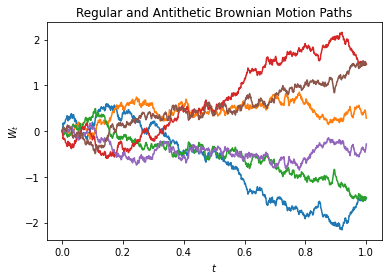

In [46]:
# E.G. of the BM sim with antithetic BM paths: there is a symmetrical nature to each path 
# which represents the negative correlation associated with each path
np.random.seed(0) 
tvec, W = bmsim_vec_av(1, 1000, numsim=3, av=True)
W = pd.DataFrame(W.transpose(), index=tvec)
W.plot().legend().remove()
plt.title('Regular and Antithetic Brownian Motion Paths')
plt.xlabel("$t$"); plt.ylabel("$W_t$");

* just need to make a relatively smaller alteration to the original vec_mc code to account for the now concatenated (z) series of correlated normal distribution draws

In [32]:
# see original MC method asian_mc_vec for step-by-step code comments
def asian_mc_vec_as(S0, K, T, r, sigma, q, N, numsim=10000, ant_sampling=True):
    """
    Monte Carlo price of an arithmetic average Asian call. 
    Antithetic Sampling default is True; set to false to return regular MC  """
    
    X0 = np.log(S0)
    nu = r-q-.5*sigma**2    
    _, X = bmsim_vec_av(T, N, X0, nu, sigma, numsim, av=True)
    S = np.exp(X)
    
    # apply payoff function for asian call (defined in the asian options introduction section)
    payoffs = np.maximum(S[:, 1:].mean(axis=1)-K, 0.)
    g = np.exp(-r*T)*payoffs
    
    if ant_sampling==True:
        g = .5*(g[:numsim]+g[numsim:])
        
    C = g.mean(); s = g.std()
    zq = norm.ppf(0.975)
    Cl = C - zq/np.sqrt(numsim)*s
    Cu = C + zq/np.sqrt(numsim)*s
    return C, Cl, Cu

In [41]:
np.random.seed(0)

# pass in dummy data
S0 = 11; K = 10; T = 3/12.; r = 0.02; sigma = .3; q = 0.01; N = 10; numsim=10000

# run the mc pricer with ant_sampling 
C_as, Cl_as, Cu_as = asian_mc_vec_as(S0, K, T, r, sigma, q, N, numsim, ant_sampling=True)

# return value and the confidence interval 
C_as

1.0839280047262243

In [42]:
print("confidence interval band asian MC with AS: {}".format(Cu_as - Cl_as))

confidence interval band asian MC with AS: 0.008919440392011424


* The confidence interval band has shrunk from 0.035 in the regular asian_mc_vec to 0.008 for the antithetic sampling version; which represents a solid improvement in variance reduction 